<a href="https://colab.research.google.com/github/chanhyeong00/machine_learning_study/blob/main/10.%20%EC%8B%9C%ED%80%80%EC%8A%A4%EB%A5%BC%20%EC%98%88%EC%B8%A1%ED%95%98%EB%8A%94%20%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D%EB%AA%A8%EB%8D%B8%20%EB%A7%8C%EB%93%A4%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

모델을 만들기 전에 먼저 머신 러닝 모델을 훈련하기 위해 시계열 데이터를 구성하는 방법을 이해해야 한다.

소위 **윈도 데이터셋(window dataset)** 이라는 것을 만든다.



In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

### 10.1. 윈도 데이터셋 만들기

In [2]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
for window in dataset:
  print(window.numpy())

[0 1 2 3 4]
[1 2 3 4 5]
[2 3 4 5 6]
[3 4 5 6 7]
[4 5 6 7 8]
[5 6 7 8 9]


1. 먼저 range 함수를 사용해 데이터셋을 만든다.
2. dataset.window를 호출하고 데이터셋을 5개의 항목으로 구성된 윈도로 나누도록 첫 번째 매개변수 5로 지정
3. shift=1 로 하면 윈도가 이전 위치에서 한 항목씩 이동. 즉 첫 번째 윈도가 0부터 5개의 항목을 포함하고, 다음 윈도는 1부터 5개 항목 포함.
4. drop_remainder=True로 지정하면 데이터셋의 마지막 부분에서 윈도 크기보다 적은 개수가 남았을 때 해당 윈도를 버리도록 한다.
5. 정의된 윈도를 사용해 데이터셋 분할 수행 가능. **flat_map** 메서드를 사용해 5개의 항목을 가진 배치를 생성한다.

(flat_map 메서드는 데이터셋 원소에 매개변수로 전달된 함수를 적용하고 그 결과를 1차원 배열로 합친다)
***

하지만 n개의 값을 특성으로 사용하고 이어지는 하나의 값을 레이블로 사용하는 훈련 데이터가 필요하다.

또 다른 람다 함수를 적용해 각 윈도를 마지막 이전의 값과 마지막 값으로 나눌 수 있다.

In [3]:
import tensorflow as tf

dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:])) ###
for x, y in dataset:
  print(x.numpy(), y.numpy())

[0 1 2 3] [4]
[1 2 3 4] [5]
[2 3 4 5] [6]
[3 4 5 6] [7]
[4 5 6 7] [8]
[5 6 7 8] [9]


데이터셋이기 때문에 람다함수를 통해 셔플링과 배치도 지원.

여기서는 셔플링을 적용한 다음 배치 크기를 2로 지정하겠다.

In [4]:
import tensorflow as tf

dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
dataset = dataset.shuffle(buffer_size=10) ###
dataset = dataset.batch(2).prefetch(1) ###

for x, y in dataset:
  print('x = ', x.numpy())
  print('y = ', y.numpy())

x =  [[4 5 6 7]
 [3 4 5 6]]
y =  [[8]
 [7]]
x =  [[1 2 3 4]
 [2 3 4 5]]
y =  [[5]
 [6]]
x =  [[5 6 7 8]
 [0 1 2 3]]
y =  [[9]
 [4]]


- prefetch() ?
  - tf.data API는 tf.data.Dataset.prefetch 변환을 제공합니다. 이를 이용해 데이터가 생성되는 시간과 데이터가 소비되는 시간을 분리할 수 있습니다. 특히 변환에 백그라운드 스레드와 내부 버퍼를 사용하여 요청된 시간보다 앞서 입력 데이터세트에서 요소를 미리 가져옵니다. 미리 가져올 요소의 수는 단일 학습 단계에서 사용되는 배치 수와 같거나 더 많아야 합니다. 이 값을 수동으로 조정하거나, tf.data 런타임이 런타임에 값을 동적으로 조정하도록 tf.data.AUTOTUNE로 설정할 수 있습니다.

  프리페치 변환은 "생산자"의 작업과 "소비자"의 작업을 겹칠 기회가 있을 때마다 이점을 제공합니다.

- 출처: https://www.tensorflow.org/guide/data_performance?hl=ko

#### 10.1.1. 윈도를 적용한 시계열 데이터셋 만들기

우선 이전 장에서 합성 시계열 데이터셋을 만들기 위해 사용했던 코드를 그대로 사용하겠다.

In [5]:
def plot_series(time, series, format='-', start=0, end=None):
  plt.plot(time[start:end], series[start:end], format)
  plt.xlabel('Time')
  plt.ylabel('Value')
  plt.grid(True)

def trend(time, slope=0):
  return slope * time

# season_time이 0.4보다 작을 때는 코사인 함수로 계절성 패턴을 정의하고
# 그렇지 않을 때는 지수 함수로 정의
# where은 첫번째 매개변수가 참(true)이면 두번쨰 값을, 거짓이면 세번째 값으로
def seasonal_pattern(season_time):
  # 임의로 지정한 패턴이다
  return np.where(season_time < 0.4,
                  np.cos(season_time * 2 * np.pi),
                  1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
  # 일정 간격마다 동일 패턴 반복
  season_time = ((time + phase) % period) / period
  return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
  rnd = np.random.RandomState(seed)
  return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype='float32')
baseline = 0
series = trend(time, .05)
amplitude = 15
slope = 0.09
noise_level = 6

# 시계열 만들기
series = baseline + trend(time, slope)

series += seasonality(time, period=365, amplitude=amplitude)
# 잡음 추가
series += noise(time, noise_level, seed=42)

시계열 데이터가 준비되면 이를 이전 절에서 살펴본 코드와 비슷하게 윈도 데이터셋으로 바꾼다. 여기서는 하나의 함수로 정의

In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(
      lambda window: (window[:-1], window[-1:])) ###

  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

tf.data.Dataset의 **from_tensor_slices** 함수는 **텐서를 Dataset으로 변환한다.** (매개변수는 텐서이고, 리턴값이 이를 변환한 데이터셋)



이제 훈련 데이터가 준비되었다. 먼저 시계열 데이터를 훈련세트와 검증 세트로 나눈다.

그다음 윈도 크기, 배치 크기, 셔플링 버퍼 크기 등을 상수로 지정

In [7]:
split_time = 1000
time_train = time[:split_time]
X_train = series[:split_time]
time_valid = time[split_time:]
X_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000
dataset = windowed_dataset(X_train, window_size, batch_size, shuffle_buffer_size)

이제 데이터는 tf.data.Dataset의 객체이다.

따라서 model.fit에 하나의 매개변수로 데이터를 전달할 수 있으며, tf.keras가 나머지를 알아서 처리

데이터를 확인해보겠다. 읽기 쉽게 batch_size 는 1로 하겠다.

In [15]:
dataset_check = windowed_dataset(series, window_size, 1, shuffle_buffer_size)
for feature, label in dataset_check.take(1):
  print(feature)
  print(label)

tf.Tensor(
[[83.469765 86.69338  86.937035 94.96796  84.99418  87.30302  89.339424
  86.875084 83.14042  87.047386 92.38866  79.85203  86.87338  81.9395
  93.375374 77.13104  82.98191  88.66419  95.85975  86.137985]], shape=(1, 20), dtype=float32)
tf.Tensor([[83.267365]], shape=(1, 1), dtype=float32)


첫 번째 숫자 리스트는 특성이다. 윈도 크기가 20이므로 1*20 크기의 텐서이다.

두 번째 숫자는 모델이 특성을 매핑할 레이블이다.(여기에서는 83.3)

다음에선 훈련을 해보겠다.

### 10.2. DNN 을 만들고 시퀀스 데이터로 훈련하기

tf.data.Dataset으로 데이터를 준비했으니 신경망 모델을 만드는 건 매우 간단하다.

간단한 DNN(심층신경망, deep~) 모델을 보겠다.

In [8]:
dataset = windowed_dataset(X_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size],
                          activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1)
])

손실함수는 회귀 문제에 널리 사용되는 MSE(평균제곱오차)로 지정한다.(이 예제는 궁극적으로 회귀 문제이다)

옵티마이저로는 확률적 경사하강법인 SGD가 좋은 선택이다. SGD는 학습률과 모멘텀(momentum) 매개변수를 받아 옵티마이저 최적화 과정을 조정.

다음 절에서 최적의 값을 찾는 방법을 알아보겠지만 일단 다음처럼 사용한다.

- 모멘텀: 기본값은 0이고, 이를 0보다 큰 값으로 지정하면 마치 이전의 그레이디언트를 가속도처럼 사용.(보통 momentum 매개변수는 0.9이상을 지정)

In [18]:
sgd = tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9)
model.compile(loss='mse', optimizer=sgd)

In [19]:
model.fit(dataset, epochs=100, verbose=1)

Epoch 1/100
31/31 [==============================] - 2s 8ms/step - loss: 246.4072
Epoch 2/100
31/31 [==============================] - 0s 2ms/step - loss: 55.7714
Epoch 3/100
31/31 [==============================] - 0s 2ms/step - loss: 50.6058
Epoch 4/100
31/31 [==============================] - 0s 2ms/step - loss: 49.7220
Epoch 5/100
31/31 [==============================] - 0s 2ms/step - loss: 49.5868
Epoch 6/100
31/31 [==============================] - 0s 2ms/step - loss: 49.2663
Epoch 7/100
31/31 [==============================] - 0s 2ms/step - loss: 48.6455
Epoch 8/100
31/31 [==============================] - 0s 2ms/step - loss: 49.4841
Epoch 9/100
31/31 [==============================] - 0s 2ms/step - loss: 49.0960
Epoch 10/100
31/31 [==============================] - 0s 2ms/step - loss: 49.0213
Epoch 11/100
31/31 [==============================] - 0s 2ms/step - loss: 48.0678
Epoch 12/100
31/31 [==============================] - 0s 3ms/step - loss: 48.5703
Epoch 13/100
31/31 [====

손실 함수값이 처음에는 높았다가 점차 낮아지는 현상을 볼 수 있다.

### 10.3. DNN의 결과 평가하기

이제 예측을 할 수 있다. 그러나 윈도 데이터셋을 사용했기 때문에 특정 개수의 타입 스텝 값을 기반으로 예측을 만든다.

다른 말로 하면 데이터가 series라는 리스트라면, 하나의 값을 예측하려면 시간 t에서 t_window_size 까지의 값을 모델에 전달해야 한다. 그러면 모델이 그 타임스텝에 대한 예측값 반환

예를 들어 타임스탭 1,020의 값 예측하려면 1,000에서 1,019까지 값 사용.

In [20]:
print(series[1000:1020])

[100.02661   97.25494   92.14167   87.97915   96.12708   94.37574
  97.46318   95.98035   98.54404   89.112816 100.30619   93.66514
 105.00891   88.50013  103.129036  93.97882   88.96105   90.04455
  91.10417   95.64974 ]


In [21]:
print(series[1020])

96.32034


훈련할 때와 입력차원 동일하게 유지하기 위해 [np.newaxis] 를 추가

위에 series를 데이터셋 변환후 출력한 거 보면 1차원 배열이고, 훈련 데이터는 2차원 배열임

-  np 행렬의 차원을 확장하는 함수

In [22]:
print(model.predict(series[1000:1020][np.newaxis]))

1/1 [==============================] - 0s 226ms/step
[[96.964035]]


In [23]:
start_point = 1000
print(series[start_point:start_point+window_size])
print(series[start_point+window_size])
print(model.predict(
    series[start_point:start_point+window_size][np.newaxis]))

[100.02661   97.25494   92.14167   87.97915   96.12708   94.37574
  97.46318   95.98035   98.54404   89.112816 100.30619   93.66514
 105.00891   88.50013  103.129036  93.97882   88.96105   90.04455
  91.10417   95.64974 ]
96.32034
1/1 [==============================] - 0s 88ms/step
[[96.964035]]


이 코드는 윈도 크기를 상당히 작은 길이인 20으로 가정했다.

결과적으로 모델의 정확도가 낮을 수 있다.

정확도는 어떻게 측정할 수 있을까?

### 10.4. 전반적인 예측 살펴보기

모델의 전체 결과를 확인하려면 모든 타임스텝에 대해 동일한 작업을 수행해야 한다.

다음처럼 간단한 루프 사용해 이 작업을 수행 가능

In [38]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(
      model.predict(series[time:time+window_size][np.newaxis]))

1/1 [==============================] - 0s 21ms/step


forecast 리스트엔 타임스탭 21부터 예측된 값이 있다.

기억을 되살려보면 타임스탭 1,000 시점에서 데이터셋을 훈련 세트와 검증세트로 나누었다. 따라서 이타임스탭 다음의 예측만 가져와야 한다.

예측한 데이터를 저장한 forecast 리스트는 20만큼 앞선 타임 스텝의 값을 저장한다. 이를 고려해 다음 코드처럼 데이터를 나누고 넘파이 배열로 변환.


In [39]:
forecast = forecast[split_time-window_size:]
print(forecast[:5])

[array([[90.634155]], dtype=float32), array([[94.070786]], dtype=float32), array([[95.738235]], dtype=float32), array([[93.26447]], dtype=float32), array([[93.12895]], dtype=float32)]


In [40]:
results = np.array(forecast)[:, 0, 0] # 전체를 행별로 슬라이싱(3차원 배열이라 3개 변수)
results[:3]

array([90.634155, 94.070786, 95.738235], dtype=float32)

이제 검증세트와 예측 데이터의 크기가 같아졌다. 그러므로 그래프를 그릴 수 있다.

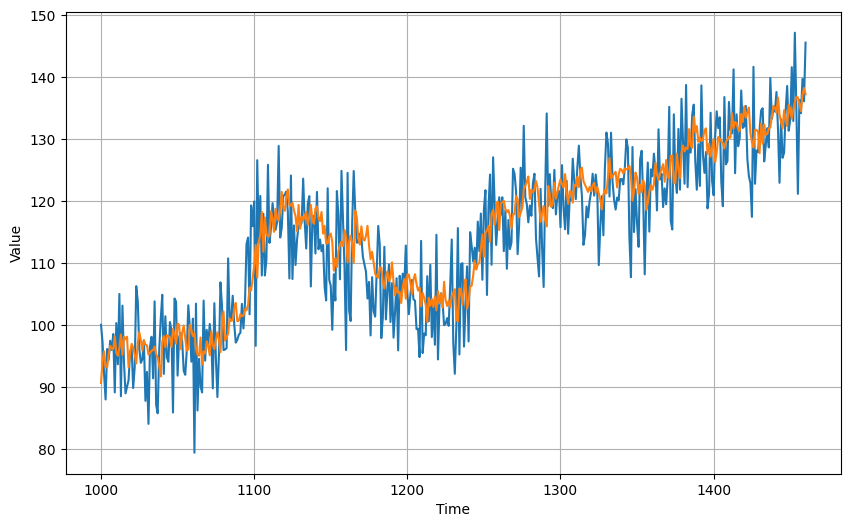

In [41]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, X_valid) # 시리즈로, 1차원 배열
plot_series(time_valid, results) # 위에서 1차원 배열로 변환함

전반적으론 예측 결과가 잘 따라간다.

눈으로 정확히 파악하긴 어려우므로 측정 지표를 사용하는 것이 좋다.

그중 하나인 MAE(평균절대오차)를 사용하겠다.

In [42]:
tf.keras.metrics.mean_absolute_error(X_valid, results).numpy()

5.3284416

여기서는 5.3을 얻었다.

가능한 한 정확한 예측을 얻는 과정이 MAE를 최소화 하는 과정이다.

윈도 크기 변경 등 여러 기법이 있지만 스스로 해볼 것.

다음 절에서는 옵티마이저에서 몇 가지 기본적인 하이퍼파라미터 튜닝을 수행하겠다.


### 10.5. 학습률 튜닝하기

위에서 학습률은 1*10^-6이었다. 하지만 이는 그냥 임의로 정한 숫자이다

이를 바꾸면 어떻게 되고, 어떻게 바꿔야 할까? 많은 실험이 필요하다.

tf.keras에는 훈련 과정에서 학습률을 조정할 수 있는 콜백 기능을 제공한다.

콜백 함수를 사용해 학습률 파라라미터를 조정하고, 적절한 에폭을 찾기 위해 손실에 대한 학습률의 값을 그래프로 그려서 최적의 학습률 결정 가능하다.

**tf.keras.callbacks.LearningRateScheduler**를 만들어 **learning_rate** 매개변수에 원하는 **시작값 지정**

In [44]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10 ** (epoch/20))

여기서는 학습률이 1e-8에서부터 시작하며 에폭마다 학습률이 조금씩 증가한다.

10번째 에폭이 끝나면 1e-3 까지 증가(100//20 = 5 라서 1e-8 * 10^5 = 10^3)

이제 학습률 1e-8로 옵티마이저를 초기화하고 콜백을 넣어 학습

In [51]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size],
                          activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1)
])
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss='mse', optimizer=optimizer)
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=0) # 학습하는 거 안 보이도록 verbose=0

**손실 그래프**

(1e-08, 0.001, 0.0, 300.0)

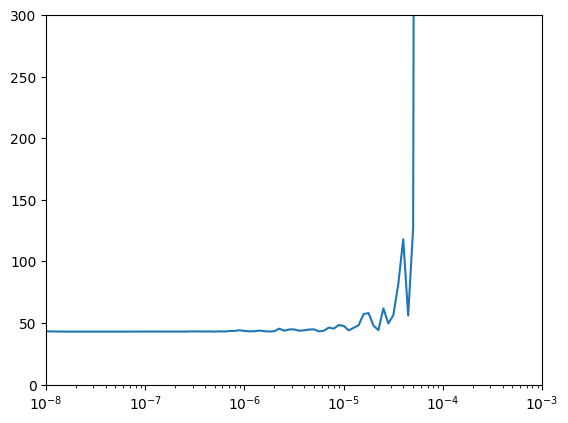

In [49]:
lrs = 1e-8 * (10 ** (np.arange(100)/20))
plt.semilogx(lrs, history.history['loss'])
plt.axis([1e-8, 1e-3, 0, 300])

크게 차이 없음 10^-6도 괜찮은 수치인 거 같다.

이런식으로 최상의 학습률을 구할 수 있다는 것을 알아두자

1. 또한 윈도우 크기도 바꿔가면서 찍어보자!

2. 에폭을 바꿔가며 해보자!

### 10.6. 케라스 튜너로 하이퍼파리미터 튜닝하기

몇 에폭마다 학습률을 변경하고 손실을 측정하는 데에는 상당한 노력이 필요하다.

또한 손실이 에폭마다 변화한다는 사실 때문에 실제로는 최적의 값이 아니라 **근삿값**을 찾는다

진짜 최상의 값을 찾으려면 개별 매개변숫값마다 전체 에폭을 훈련해서 결과를 비교해야 한다. 이는 학습률 하나의 파라미터에 대한 것이다.

***
최상의 모멘텀 값이나, 모델 구조에 해당하는 층의 뉴런 개수, 층 개수 등과 같은 다른 하이퍼파라미터에 대한 최상의 값을 찾으려면 테스트할 옵션이 순식간에 수천개로 늘어난다.

그러나 다행히 케라스튜너를 이용하면 비교적 쉽게 이 문제를 해결할 수 있다.

In [11]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.4 MB/s eta 0:00:00


테스트할 범위를 지정해 하이퍼파라미터를 매개변수화 할 수 있다.

- **케라스 튜너는 가능한 파라미터 조합에 대해 하나씩 여러 개의 모델을 훈련하고, 지정한 측정 지표로 모델을 평가해 최상의 모델을 리포트한다.**

여기서는 케라스 튜너가 제공하는 모든 옵션을 설명하지는 않지만 간단히 사용예제를 보겠다.

위에선 Dense 층에 10개의 뉴런 사용.

더 많은 뉴런이 있다면 모델의 성능이 올라갈까? 예를 들어 입력 층의 뉴런을 30개까지 늘려보면 어떨까?

하드코딩된 10이 아닌 다른 값을 테스트하고 싶다면 다음처럼 범위 형식으로 지정할 수 있다.

In [53]:
tf.keras.layers.Dense(units=hp.Int('units', min_value=10, max_value=30, step=2),
                      activation='relu', input_shape=[window_size])

NameError: name 'hp' is not defined

이제 케라스 튜너는 모델을 한 번 훈련하고 손실을 확인하는 것이 아니라 11번 훈련한다.

또한 모델을 컴파일 할 때 momentum=0.9로 하드코딩했다.

하지만 hp.Choice 클래스를 사용해 여러 개의 옵션을 테스트하도록 바꿀 수 있다.

In [56]:
sgd = tf.keras.optimizers.SGD(
    hp.Choice('momentum', values=[.9, .7, .5, .3]), lr=1e-5)
)
model.compile(loss='mse', optimizer=sgd)

NameError: name 'hp' is not defined

모멘텀 옵션을 4개나 제공하므로 이전에 정의한 뉴런 개수와 합치면 가능한 조합이 44개가 된다.

케라스 튜너가 다양한 조합을 테스트하고 최상의 성능을 내는 모델을 리포트한다.

모델 생성 함수를 작성해 설정을 완료하겠다. 바뀐 모델 정의는 다음과 같다.

In [9]:
def build_model(hp):
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Dense(
      units=hp.Int('units', min_value=10, max_value=30, step=2),
      activation='relu', input_shape=[window_size]))
  model.add(tf.keras.layers.Dense(10, activation='relu'))
  model.add(tf.keras.layers.Dense(1))

  sgd = tf.keras.optimizers.SGD(
      learning_rate=1e-5,
      momentum = hp.Choice('momentum', values=[.9, .7, .5, .3]))
  model.compile(loss='mse', optimizer=sgd)
  return model

이제 케라스 튜너의 RandomSearch 객체를 만들어 모델의 하이퍼파라미터 탐색을 위임한다.

In [12]:
from keras_tuner.tuners import RandomSearch
tuner = RandomSearch(build_model,
                     objective='loss', max_trials=150,
                     executions_per_trial=3, directory='my_dir',
                     project_name = 'hello') # 150 * 3 = 450번의 훈련을 함

- 앞서 설명한 build_model 함수를 전달해 모델을 정의한다.

- 하이퍼파라미터 매개변수(hp)를 사용해 어떤 값을 바꿀지 제어한다.

- 손실을 최소화하기 위해 objective 매개변수를 'loss'로 지정한다.

- max_trials 매개변수로 최대 탐색 횟수를 제한한다.

- executions_per_trial 매개변수로 (랜덤한 변동을 줄이기 위해) 모델 훈련과 평가 횟수 지정(같은 모델로 몇 번 훈련할지)


https://www.tensorflow.org/tutorials/keras/keras_tuner?hl=ko

탐색을 시작하려면 model.fit을 호출하는 것처럼 tuner.search 호출

In [13]:
tuner.search(dataset, epochs=100, verbose=0)

실행이 끝나면 results_summary 를 호출해 최상위 10개의 모델을 확인할 수 있다.

In [14]:
tuner.results_summary()

Results summary
Results in my_dir/hello
Showing 10 best trials
Objective(name="loss", direction="min")

Trial 009 summary
Hyperparameters:
units: 14
momentum: 0.9
Score: 41.09367879231771

Trial 024 summary
Hyperparameters:
units: 30
momentum: 0.7
Score: 41.35909907023112

Trial 036 summary
Hyperparameters:
units: 26
momentum: 0.9
Score: 41.37073516845703

Trial 032 summary
Hyperparameters:
units: 30
momentum: 0.9
Score: 41.449475606282554

Trial 030 summary
Hyperparameters:
units: 20
momentum: 0.9
Score: 41.558695475260414

Trial 035 summary
Hyperparameters:
units: 28
momentum: 0.7
Score: 41.64605585734049

Trial 003 summary
Hyperparameters:
units: 20
momentum: 0.5
Score: 41.68597284952799

Trial 022 summary
Hyperparameters:
units: 16
momentum: 0.9
Score: 41.770514170328774

Trial 001 summary
Hyperparameters:
units: 18
momentum: 0.7
Score: 41.847887674967446

Trial 029 summary
Hyperparameters:
units: 18
momentum: 0.9
Score: 41.876678466796875


결과를 보면 모멘텀 0.9와 입력 유닛 14개에서 최선의 손실 점수를 달성했다.

get_best_models 메서드로 이 모델과 다른 최상의 모델을 원하는 개수만큼 추출할 수 있다.

예를 들어 상위 네 개의 모델을 추출하려면 다음과 같이 호출한다.

In [15]:
best_models = tuner.get_best_models(num_models=4)

그다음 이 모델을 테스트할 수 있다.

또는 찾은 하이퍼파라미터로 다음처럼 새로운 모델을 만들 수 있다.

In [22]:
model = best_models[0]

forecast = []
for time in range(len(series) - window_size):
    forecast.append(
        model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

1/1 [==============================] - 0s 18ms/step


이 하이퍼파라미터로 훈련해 이전처럼 검증 세트에 대해 예측 수행하면 다음과 같은 그래프를 얻는다.

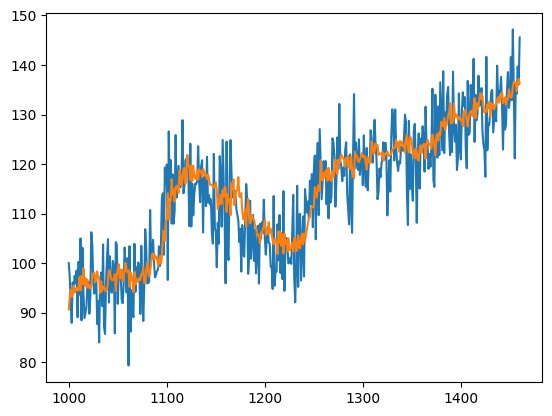

In [24]:
plt.plot(time_valid, X_valid)
plt.plot(time_valid, results)

In [23]:
tf.keras.metrics.mean_absolute_error(X_valid, results).numpy()

5.2833714

최종 MAE가 5.32에서 0.3 내려가 개선되었다.(랜덤이라 이전 장과는 비교하지 않겠다)

아마 learning_rate를 위에서 찾은 1e-6이 아닌 1e-5로 해서 그런 듯 하다.


튜닝을 더 해볼 순 있지만 학습 시간(50분)이 너무 길어서 해보진 않겠다